<center><h1>Apollo Hospitals</h1></center>

The company wants to know:

- Which variables are significant in predicting the reason for hospitalization for different regions

- How well some variables like viral load, smoking, Severity Level describe the hospitalization charges

## Column Profiling-

- Age: This is an integer indicating the age of the primary beneficiary (excluding those above 64 years, since they are generally covered by the government).
- Sex: This is the policy holder's gender, either male or female
- Viral Load: Viral load refers to the amount of virus in an infected person's blood
- Severity Level: This is an integer indicating how severe the patient is
- Smoker: This is yes or no depending on whether the insured regularly smokes tobacco.
- Region: This is the beneficiary's place of residence in Delhi, divided into four geographic regions - northeast, southeast, southwest, or northwest
- Hospitalization charges: Individual medical costs billed to health insurance

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns
from scipy import stats

In [3]:
data = pd.read_csv("scaler_apollo_hospitals.csv", index_col=0)
data.head()

,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,19,female,yes,southwest,9.30,0,42212
1,18,male,no,southeast,11.26,1,4314
2,28,male,no,southeast,11.00,3,11124
3,33,male,no,northwest,7.57,0,54961
4,32,male,no,northwest,9.63,0,9667


## 1. Analysing Basic metrics

In [4]:
data.shape

(1338, 7)

In [23]:
## No null values in data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   age                      1338 non-null   int64   
 1   sex                      1338 non-null   category
 2   smoker                   1338 non-null   category
 3   region                   1338 non-null   category
 4   viral_load               1338 non-null   float64 
 5   severity_level           1338 non-null   category
 6   hospitalization_charges  1338 non-null   int64   
dtypes: category(4), float64(1), int64(2)
memory usage: 47.7 KB


In [6]:
## 4 columns have very less unique values

data.nunique(dropna=False)

age                          47
sex                           2
smoker                        2
region                        4
viral load                  462
severity level                6
hospitalization charges    1320
dtype: int64

In [14]:
## replacing " " in column names with "_"
data.columns = [i.replace(" ", "_") for i in data.columns]

## converting appropriate columns to category type
data = data.astype({i:"category" for i in ["sex", "smoker", "region", "severity_level"]})
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   age                      1338 non-null   int64   
 1   sex                      1338 non-null   category
 2   smoker                   1338 non-null   category
 3   region                   1338 non-null   category
 4   viral_load               1338 non-null   float64 
 5   severity_level           1338 non-null   category
 6   hospitalization_charges  1338 non-null   int64   
dtypes: category(4), float64(1), int64(2)
memory usage: 47.7 KB


In [24]:
## age ranges from 18 to 64 with mean 39.2
## viral_load ranges from 5.3 to 17.7 with mean 10.2
## hospitalization_charges ranges from 2805 to 159426 with mean 33176

data.describe()

,age,viral_load,hospitalization_charges
count,1338.000000,1338.000000,1338.000000
mean,39.207025,10.221233,33176.058296
std,14.049960,2.032796,30275.029296
min,18.000000,5.320000,2805.000000
25%,27.000000,8.762500,11851.000000
50%,39.000000,10.130000,23455.000000
75%,51.000000,11.567500,41599.500000
max,64.000000,17.710000,159426.000000


In [21]:
## More male data is there
## large number of non smokers
## 0 severity_level is most common

data.describe(include=["O", "category"])

,sex,smoker,region,severity_level
count,1338,1338,1338,1338
unique,2,2,4,6
top,male,no,southeast,0
freq,676,1064,364,574


In [25]:
## Checking % proportion for category columns

for column in ["sex", "smoker", "severity_level", "region"]:
    print(column+' % Proportion:')
    display(
        round((data[column].value_counts(normalize=True) *100), 2)
    )
    print('-'*50)


sex % Proportion:


male      50.52
female    49.48
Name: sex, dtype: float64

--------------------------------------------------
smoker % Proportion:


no     79.52
yes    20.48
Name: smoker, dtype: float64

--------------------------------------------------
severity_level % Proportion:


0    42.90
1    24.22
2    17.94
3    11.73
4     1.87
5     1.35
Name: severity_level, dtype: float64

--------------------------------------------------
region % Proportion:


southeast    27.20
northwest    24.29
southwest    24.29
northeast    24.22
Name: region, dtype: float64

--------------------------------------------------


In [43]:
pd.crosstab(index=[data.sex,  data.smoker,],
            columns=[data.region, ],
            margins=True, 
            normalize=True
            )\
                .style.background_gradient(cmap='YlGnBu')\
                    .format('{:.2%}')


In [62]:
pd.crosstab(index=data.region, 
            columns=data.severity_level, 
            margins=True,
            normalize=True,
            )\
                .style.background_gradient(cmap='YlGnBu')\
                    .format('{:.2%}')

severity_level,0,1,2,3,4,5,All
region,,,,,,,
northeast,10.99%,5.75%,3.81%,2.91%,0.52%,0.22%,24.22%
northwest,9.87%,5.53%,4.93%,3.44%,0.45%,0.07%,24.29%
southeast,11.73%,7.10%,4.93%,2.62%,0.37%,0.45%,27.20%
southwest,10.31%,5.83%,4.26%,2.77%,0.52%,0.60%,24.29%
All,42.90%,24.22%,17.94%,11.73%,1.87%,1.35%,100.00%


In [63]:
pd.crosstab(index=data.region, 
            columns=data.sex, 
            margins=True,
            normalize=True,
            )\
                .style.background_gradient(cmap='YlGnBu')\
                .format('{:.2%}')


sex,female,male,All
region,,,
northeast,12.03%,12.18%,24.22%
northwest,12.26%,12.03%,24.29%
southeast,13.08%,14.13%,27.20%
southwest,12.11%,12.18%,24.29%
All,49.48%,50.52%,100.00%


<div class="alert alert-block alert-info">
<h3>Observations:</h3> 
    1. Male and female proportion is almost equal.<br>
    2. Around 80% people in dataset are non smoker.<br>
    3. More than 60% people have severity level less than 2.<br>
    4. More male smokers are there in southeast and southwest region than female smokers.<br>
    5. Southeast region has highest severity 0 level patients.<br>
    6. Southeast region has around 1% more male patients than female.<br> 
    7. That might be because around 2% more male smokers are there in southeast than female smokers.<br>
</div>

<hr>

## 2. Univariate Analysis

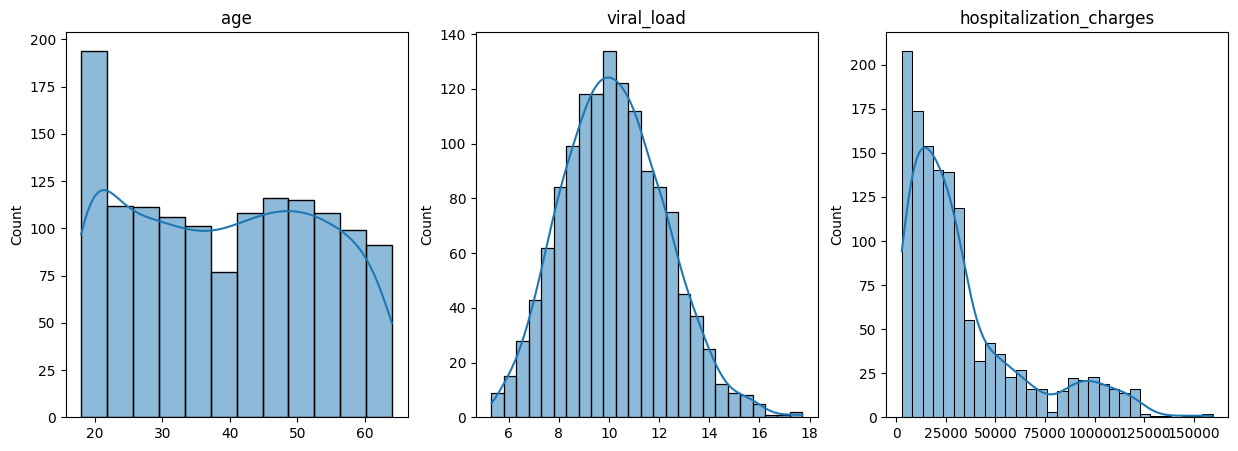

In [143]:
## histograms and boxplot for numerical columns

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
plt.subplots_adjust(hspace=0.3)

for i, ax in zip(data.select_dtypes(exclude='category'), axs.ravel()):
    sns.histplot(data, x=i, kde=True, ax=ax)
    ax.set_title(i)
    ax.set_xlabel('')


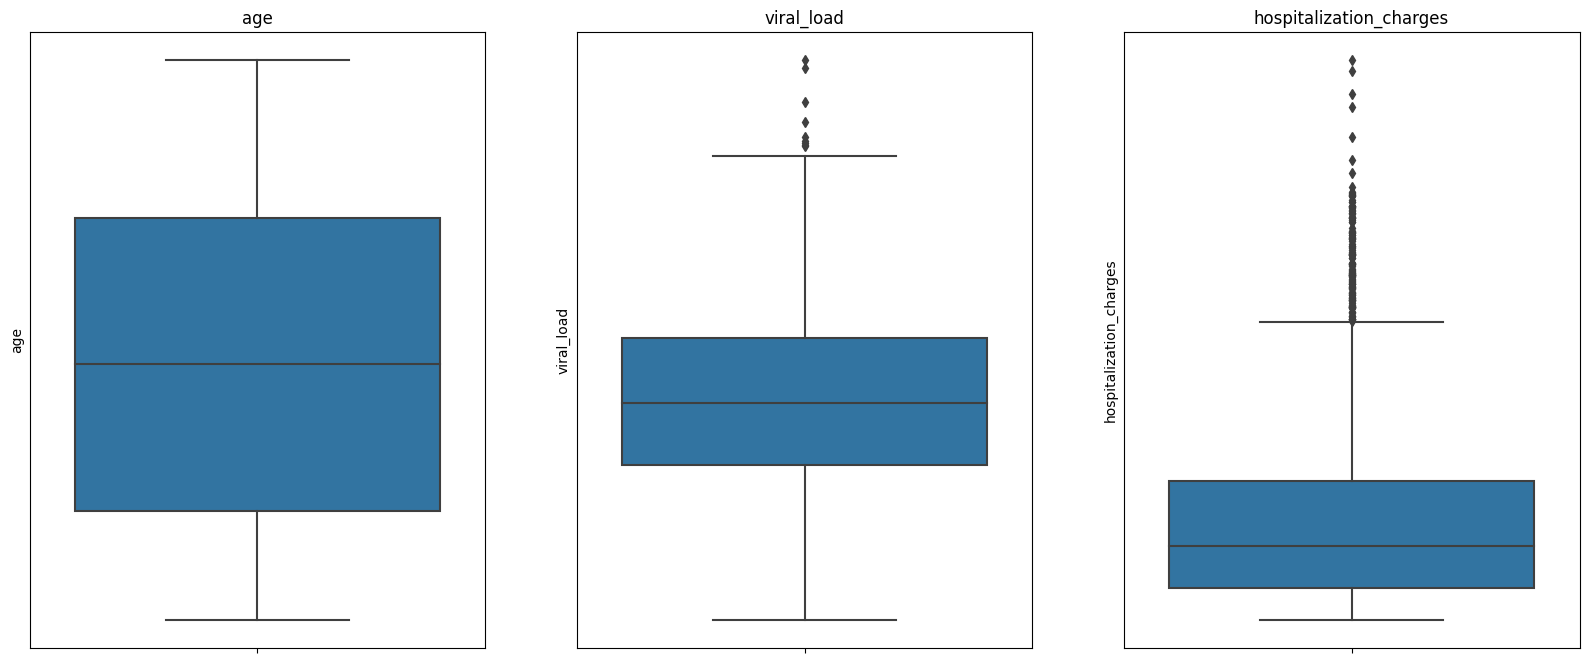

In [141]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))
plt.subplots_adjust(hspace=0.2)

for i, ax in zip(data.select_dtypes(exclude=['object', 'category']), axs.ravel()):
    sns.boxplot(y=data[i], ax=ax)
    ax.set_title(i)
    ax.tick_params(
        # axis='x',          
        which='both',     
        left=False,          
        labelleft=False, 
        labeltop=False) 

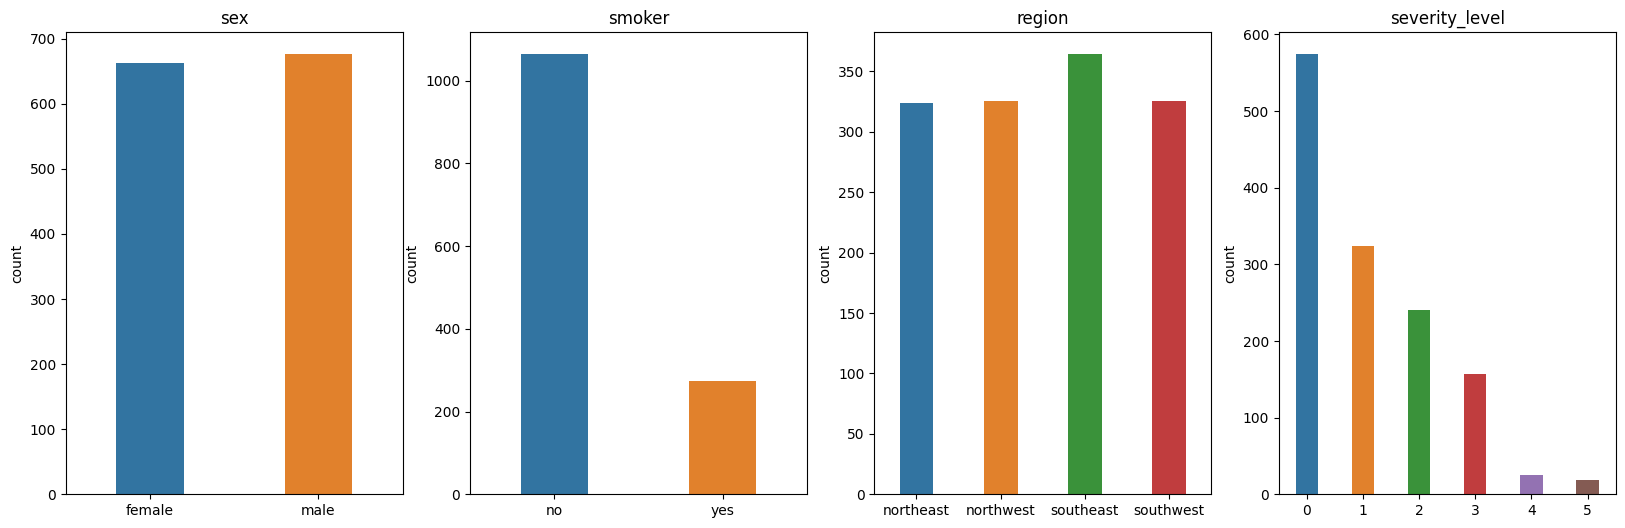

In [147]:
## count plots for category columns
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 6))
plt.subplots_adjust(hspace=0.6)

for i, ax in zip(data.select_dtypes(['category']), axs.ravel()):
    sns.countplot(x=data[i],width=0.4, ax=ax)
    ax.set_title(i)
    ax.set_xlabel('')

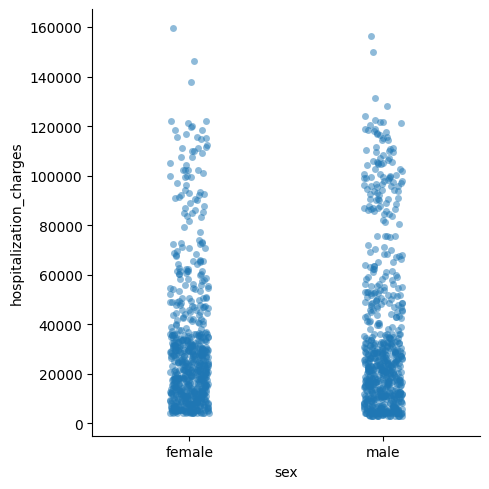

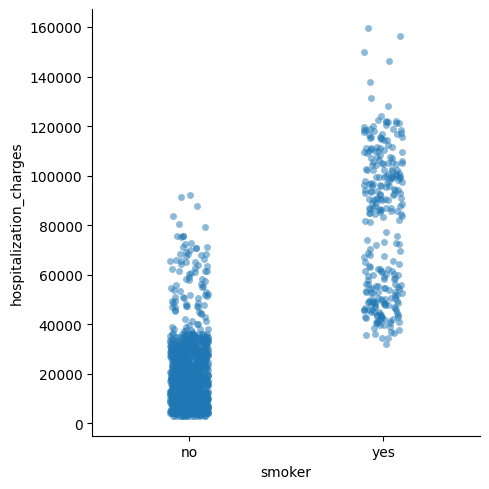

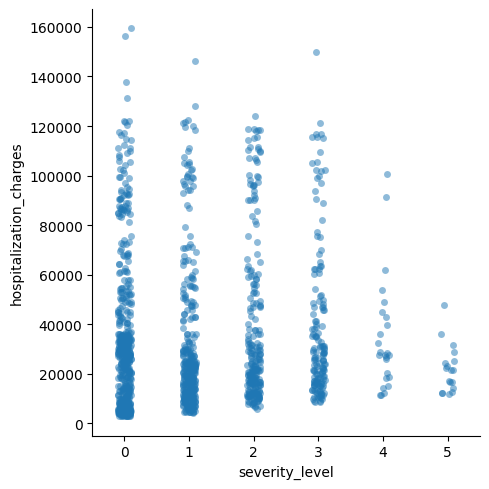

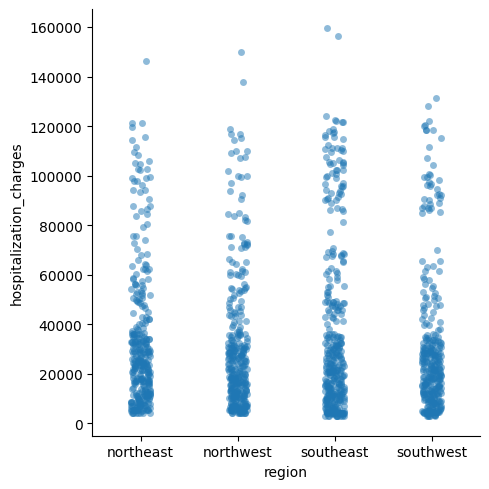

In [154]:
for col in ["sex", "smoker", "severity_level", "region"]:
    sns.catplot(data, x=col, y="hospitalization_charges", alpha=0.5)

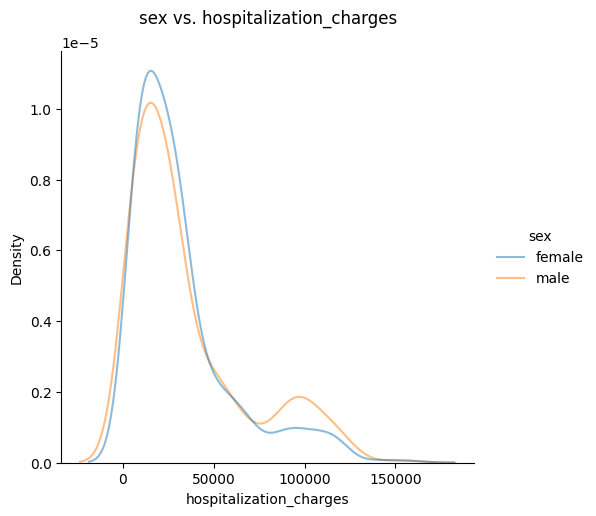

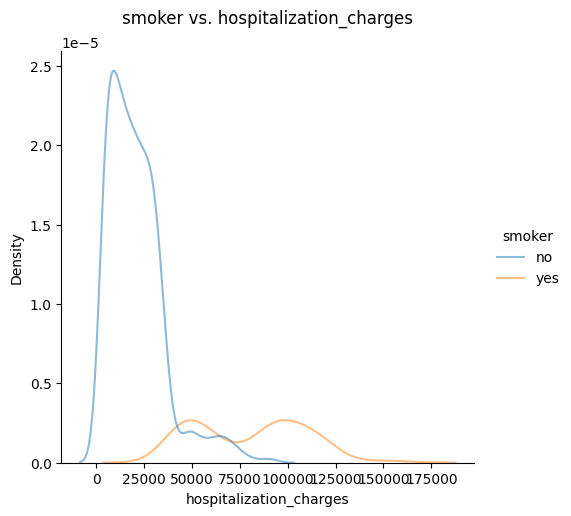

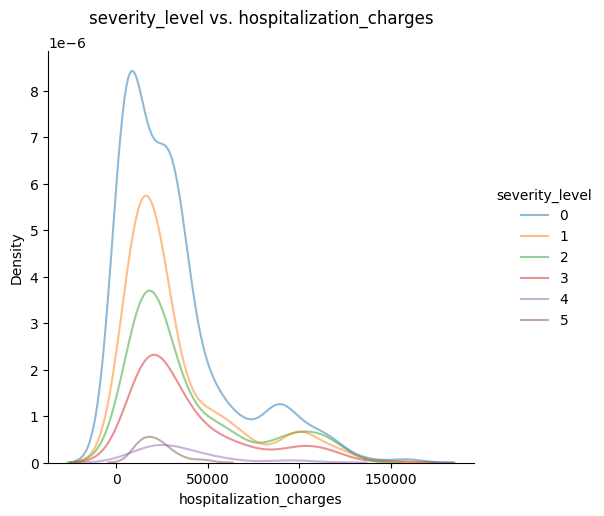

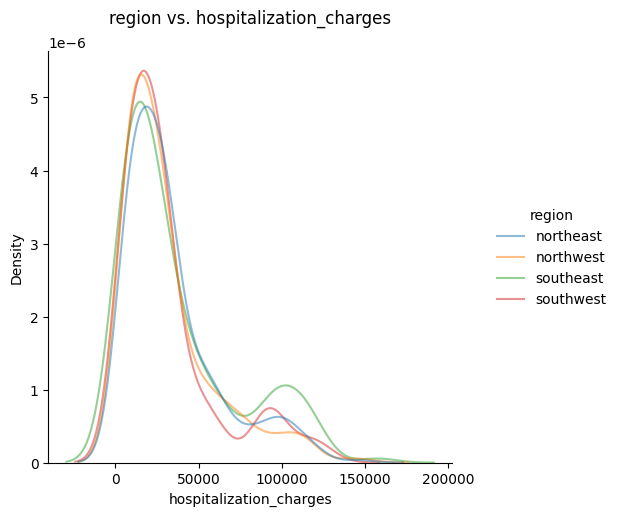

In [178]:
for col in ["sex", "smoker", "severity_level", "region"]:
    sns.displot(data, x="hospitalization_charges", hue=col, alpha=0.5, kind='kde')
    plt.title(col+' vs. hospitalization_charges', pad=20)
    # print()

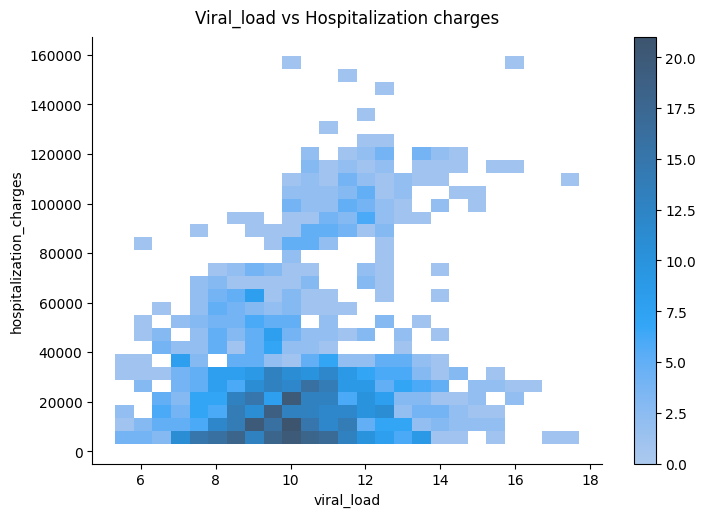

In [175]:
sns.displot(data, x="viral_load", y="hospitalization_charges",  aspect=1.5, cbar=True)
plt.title("Viral_load vs Hospitalization charges", pad=10)
plt.show()

Text(0.5, 1.0, 'Proportion plot for Smoker vs Hospitalization_charges')

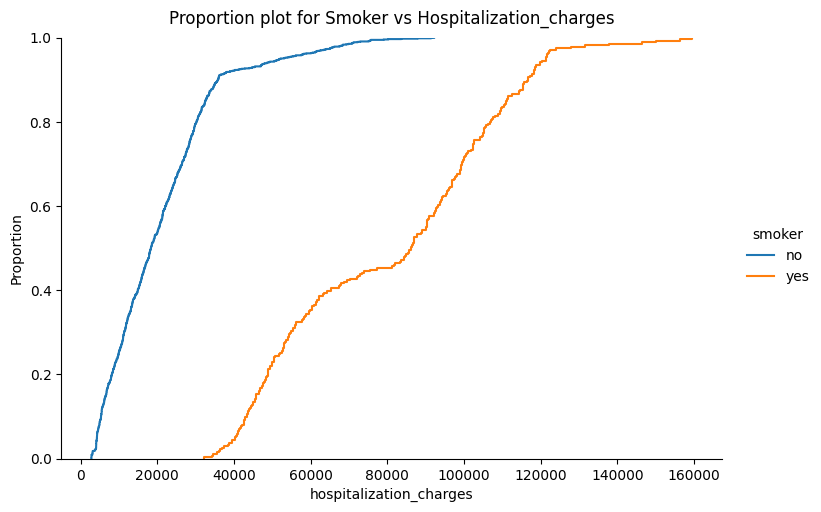

In [176]:
sns.displot(data, hue="smoker", x="hospitalization_charges", kind="ecdf", aspect=1.5)
plt.title("Proportion plot for Smoker vs Hospitalization_charges", pad=10)

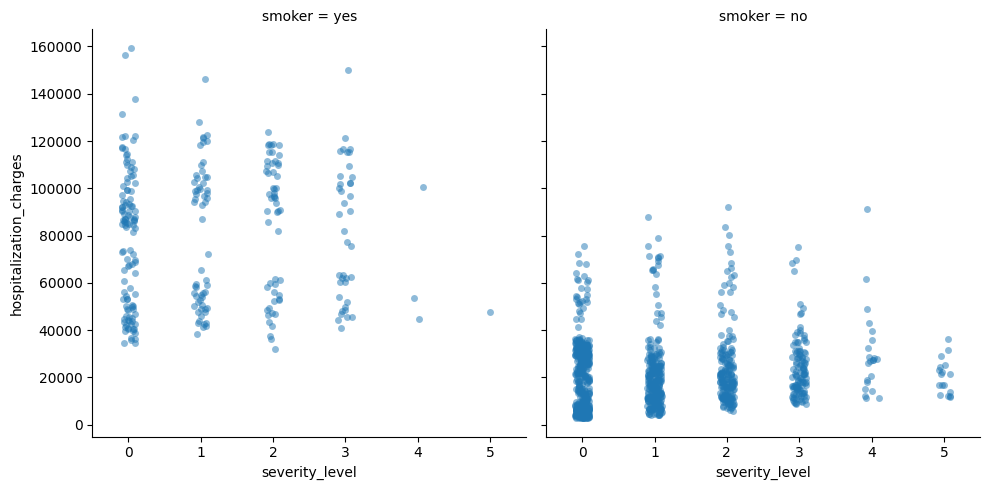

In [15]:
sns.catplot(data, y="hospitalization_charges", x="severity_level", col="smoker", alpha=0.5)

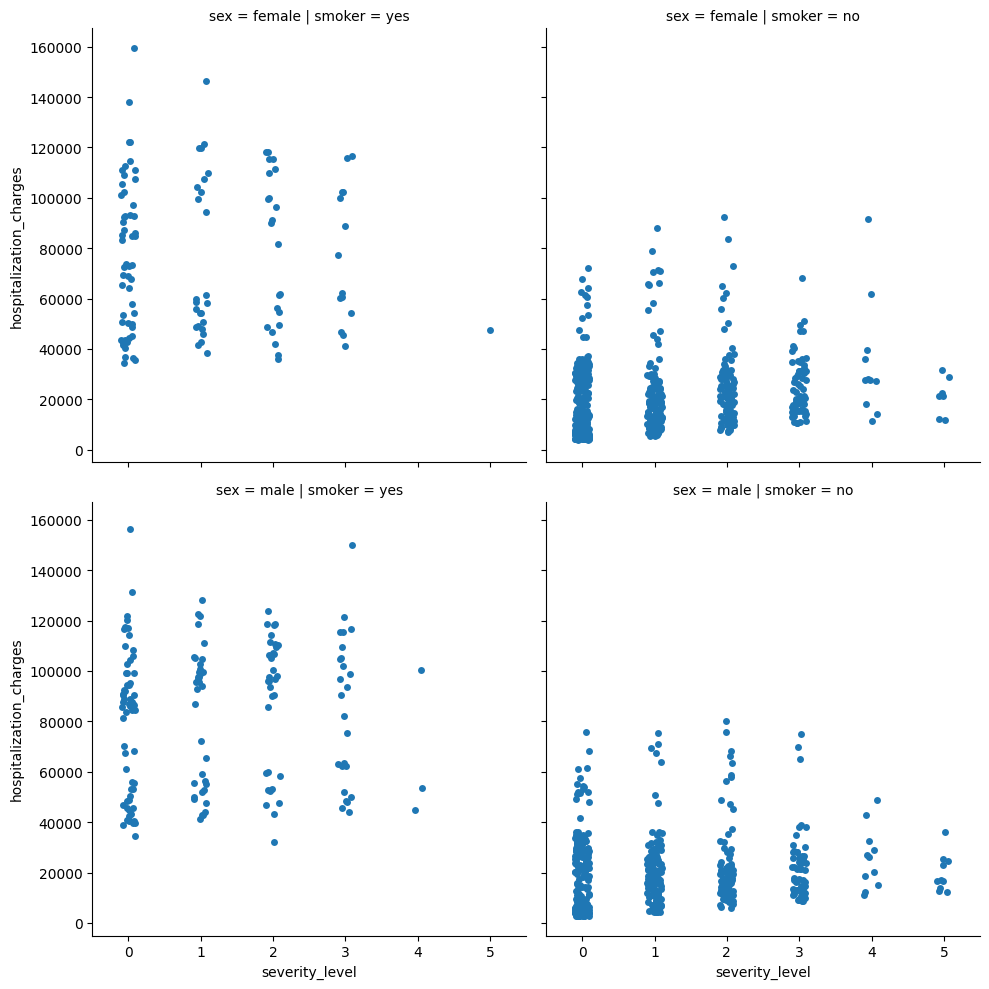

In [16]:
sns.catplot(data, y="hospitalization_charges", x="severity_level", row="sex", col="smoker")

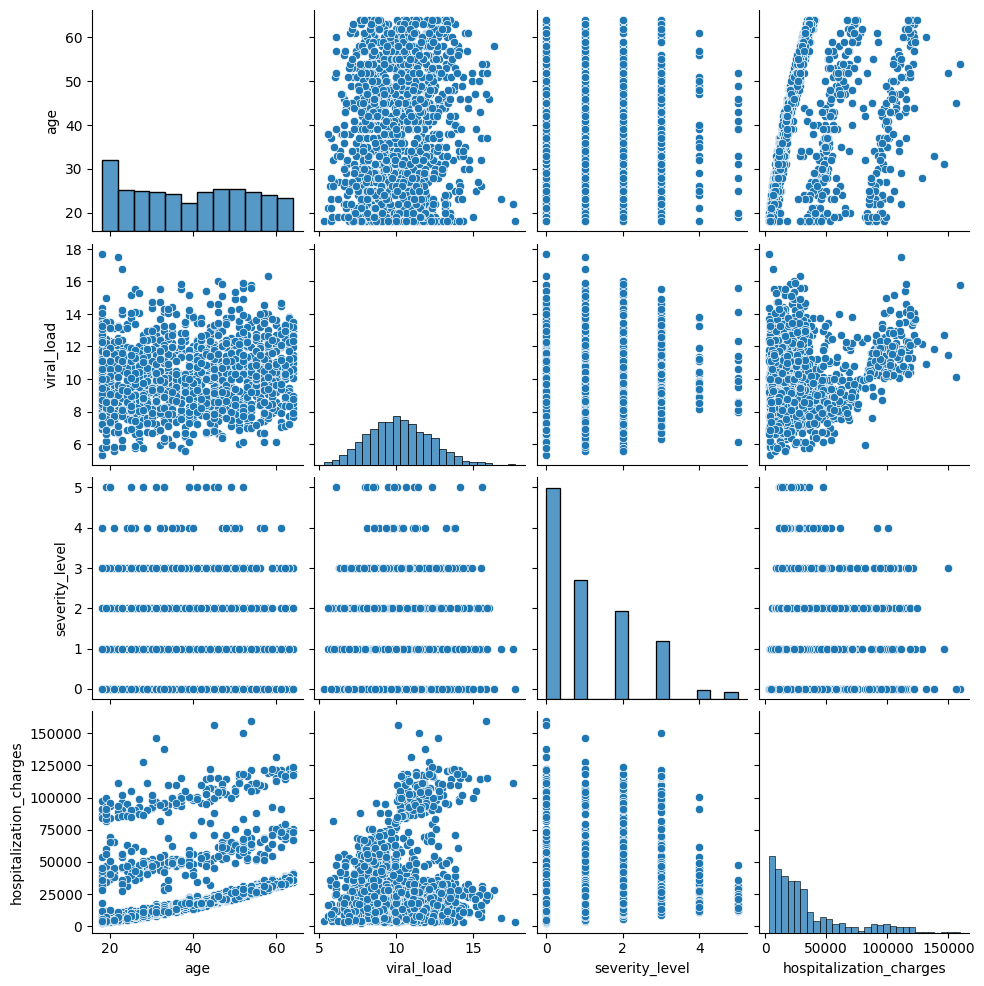

In [17]:
sns.pairplot(data)

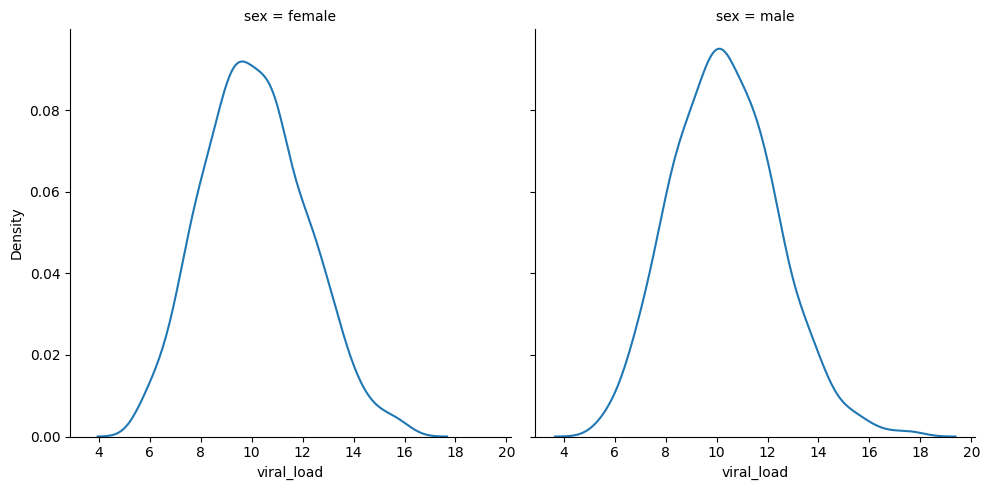

In [18]:
sns.displot(data,  x="viral_load", col="sex", kind="kde")

In [20]:
data.corr(numeric_only=True)

,age,viral_load,severity_level,hospitalization_charges
age,1.000000,0.109300,0.042469,0.299008
viral_load,0.109300,1.000000,0.012729,0.198388
severity_level,0.042469,0.012729,1.000000,0.067998
hospitalization_charges,0.299008,0.198388,0.067998,1.000000


In [21]:
data.corr(numeric_only=True, method="spearman")

,age,viral_load,severity_level,hospitalization_charges
age,1.000000,0.107743,0.056992,0.534391
viral_load,0.107743,1.000000,0.015593,0.119487
severity_level,0.056992,0.015593,1.000000,0.133342
hospitalization_charges,0.534391,0.119487,0.133342,1.000000


## Statistical Analysis:

- Prove (or disprove) that the hospitalization of people who do smoking is greater than those who don't? (T-test Right tailed)

- Prove (or disprove) with statistical evidence that the viral load of females is different from that of males (T-test Two tailed)

- Is the proportion of smoking significantly different across different regions? (Chi-square)

- Is the mean viral load of women with 0 Severity level , 1 Severity level, and 2 Severity level the same? Explain your answer with statistical evidence (One way Anova)

In [181]:
def hypothesis_result(p_value):
    significance_level = 0.05
    if p_value <= significance_level: 
        print('Reject NULL HYPOTHESIS') 
    else: 
        print('Fail to Reject NULL HYPOTHESIS') 

In [182]:
charges = data["hospitalization_charges"]

In [183]:
non_smoker_charges = data.query('smoker == "no"').hospitalization_charges.values
smoker_charges = data.query('smoker == "yes"').hospitalization_charges.values

In [184]:
stats.shapiro(np.log(charges))

ShapiroResult(statistic=0.9831621050834656, pvalue=2.285247338584817e-11)

<Axes: ylabel='Density'>

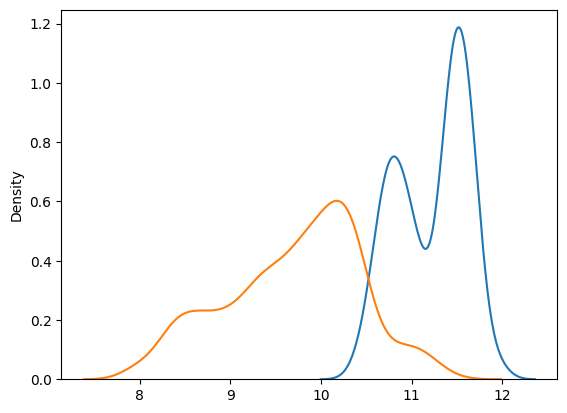

In [186]:
sns.kdeplot(np.log(smoker_charges))
sns.kdeplot(np.log(non_smoker_charges))

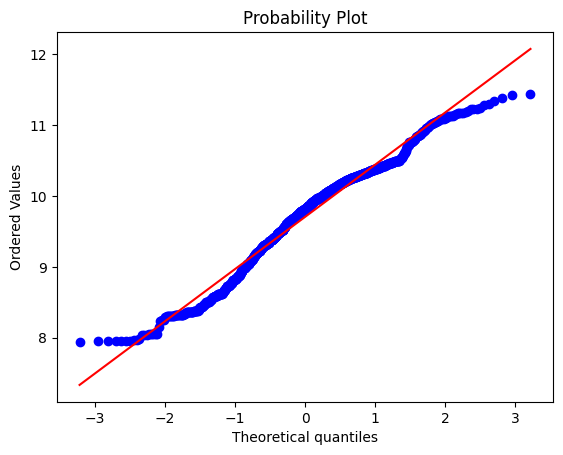

In [187]:
stats.probplot(np.log(non_smoker_charges), plot=plt)
plt.show()

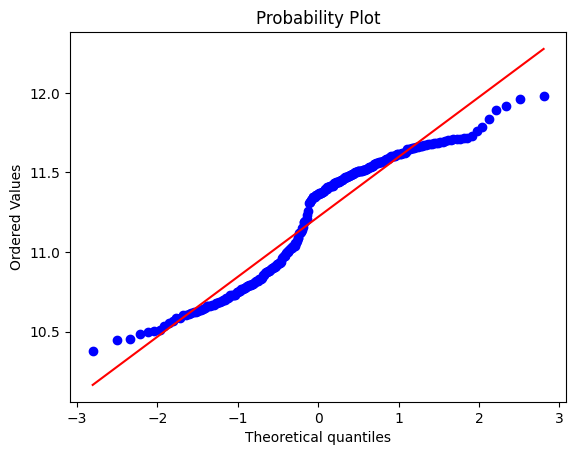

In [190]:
stats.probplot(np.log(smoker_charges), plot=plt)
plt.show()

## Assessing the Assumptions of Homogeneity
The assumption of homogeneity of variance means that the level of variance for a particular variable is constant across the sample. 

If you’ve collected groups of data then this means that the variance of your outcome variable(s) should be the same in each of these groups (i.e. across schools, years, testing groups or predicted values).

The assumption of homogeneity is important for ANOVA testing and in regression models. In ANOVA, when homogeneity of variance is violated there is a greater probability of falsely rejecting the null hypothesis. In regression models, the assumption comes in to play with regards to residuals (aka errors).

Levene's test is used to test if k samples have equal variances. Equal variances across samples is called homogeneity of variance. Some statistical tests, for example the analysis of variance, assume that variances are equal across groups or samples. The Levene test can be used to verify that assumption.

In [29]:
stats.levene(smoker_charges,non_smoker_charges)

LeveneResult(statistic=332.6132009308764, pvalue=1.5595259401311176e-66)

In [30]:
stats.ttest_ind(smoker_charges, non_smoker_charges, alternative='two-sided', equal_var=False)

Ttest_indResult(statistic=32.751856578287196, pvalue=5.890945350773759e-103)

In [31]:
stats.ttest_ind(smoker_charges, non_smoker_charges, alternative='less', equal_var=False)

Ttest_indResult(statistic=32.751856578287196, pvalue=1.0)

In [32]:

stats.ttest_ind(smoker_charges, non_smoker_charges, alternative='greater', equal_var=False)

Ttest_indResult(statistic=32.751856578287196, pvalue=2.9454726753868796e-103)

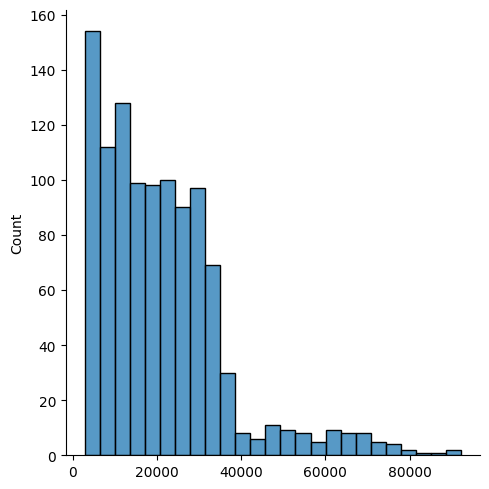

In [34]:
sns.displot(non_smoker_charges)

In [53]:
stats.skew(smoker_charges), stats.skew(non_smoker_charges)

(0.12751309394152952, 1.535952924986278)

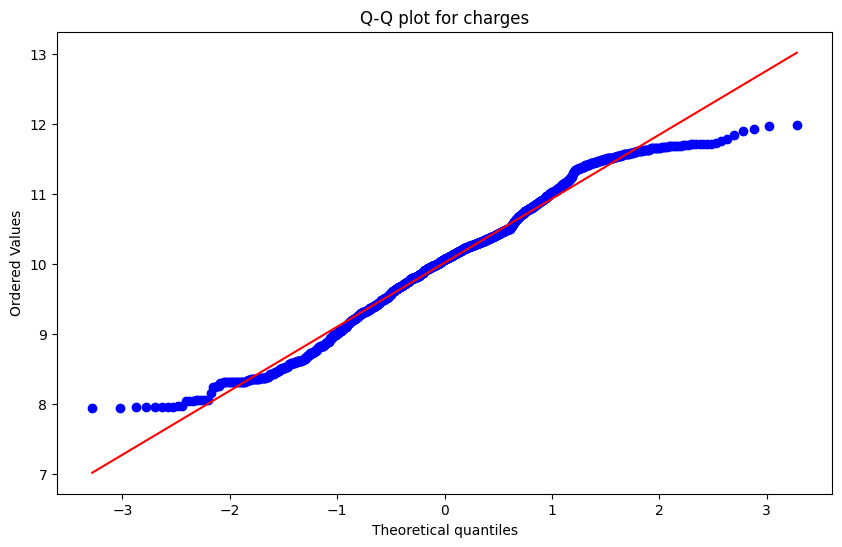

In [191]:
plt.figure(figsize=(10,6))
stats.probplot(np.log(data.hospitalization_charges), plot= plt, dist="norm")
plt.title('Q-Q plot for charges')
plt.show()

In [38]:
stats.shapiro(np.log(data["hospitalization_charges"]))

ShapiroResult(statistic=0.9831621050834656, pvalue=2.285247338584817e-11)

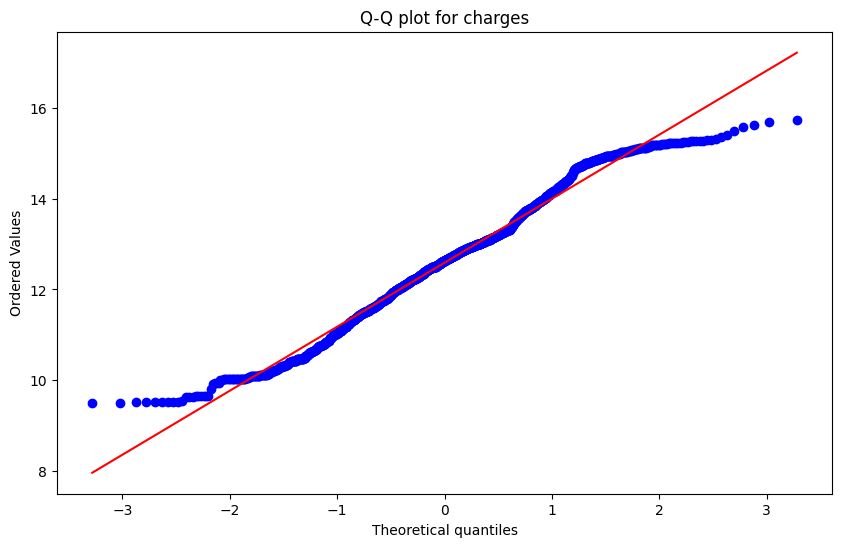

In [39]:
plt.figure(figsize=(10,6))
stats.probplot(stats.boxcox(data['hospitalization_charges'])[0], plot= plt, dist="norm")
plt.title('Q-Q plot for charges')
plt.show()


In [40]:
stats.shapiro(stats.boxcox(data['hospitalization_charges'])[0])

ShapiroResult(statistic=0.9835082292556763, pvalue=3.239270657262594e-11)

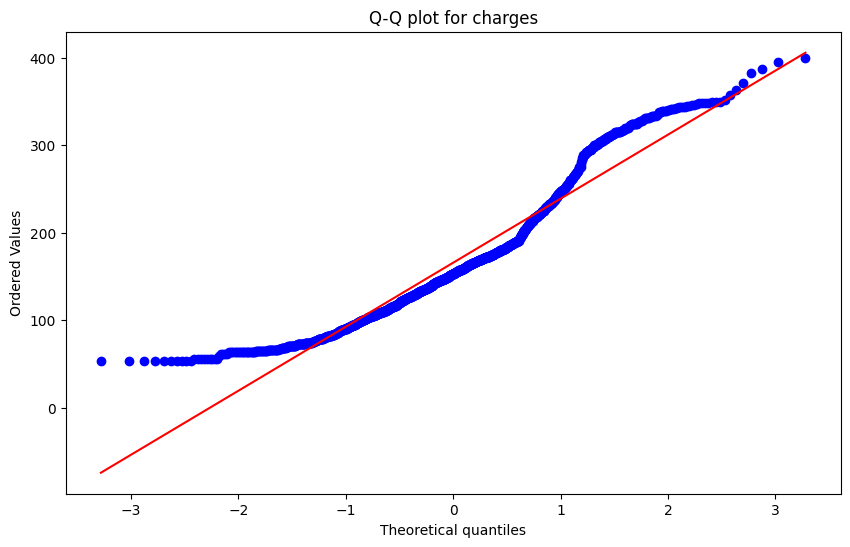

In [41]:
plt.figure(figsize=(10,6))
stats.probplot(np.sqrt(data['hospitalization_charges']).values, plot= plt, dist="norm")
plt.title('Q-Q plot for charges')
plt.show()


In [42]:
stats.shapiro(np.sqrt(data['hospitalization_charges']))

ShapiroResult(statistic=0.9338579773902893, pvalue=6.743911136444728e-24)

In [43]:
charges = data["hospitalization_charges"]
charges[(np.abs(stats.zscore(charges)) < 3)]
stats.shapiro(np.log(charges))

ShapiroResult(statistic=0.9831621050834656, pvalue=2.285247338584817e-11)

In [44]:
charges = data["hospitalization_charges"]
charges = charges[(charges > charges.quantile(0.05)) & (charges < charges.quantile(0.95))]
charges

0       42212
2       11124
3       54961
4        9667
5        9392
        ...  
1332    28529
1333    26501
1334     5515
1336     5020
1337    72853
Name: hospitalization_charges, Length: 1204, dtype: int64

In [45]:
viral_f = data.query('sex=="female"')["viral_load"].values
viral_m = data.query('sex=="male"')["viral_load"].values

stats.ttest_ind(viral_f, viral_m)

Ttest_indResult(statistic=-1.695711164450323, pvalue=0.0901735841670204)

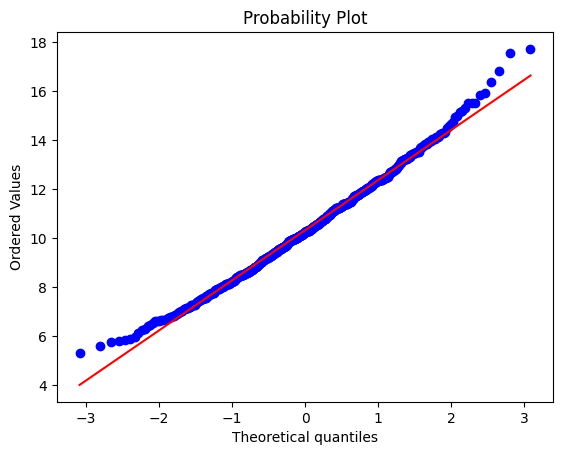

In [46]:
stats.probplot(viral_m, plot=plt, dist='norm')
plt.show()

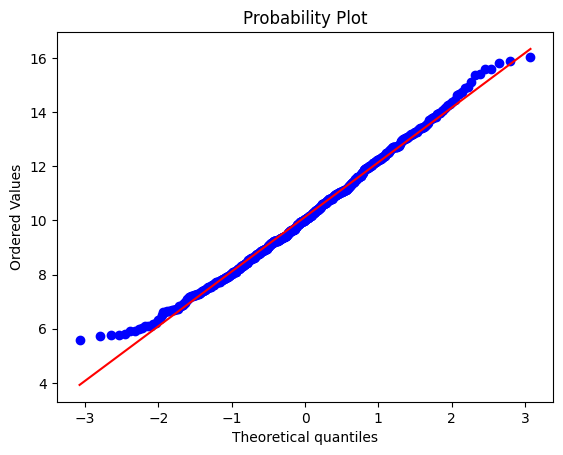

In [47]:
stats.probplot(viral_f, plot=plt, dist='norm')
plt.show()

In [48]:
observed = pd.crosstab(index=data["region"], columns=data["smoker"])

stats.chi2_contingency(observed.values)

Chi2ContingencyResult(statistic=7.343477761407071, pvalue=0.06171954839170541, dof=3, expected_freq=array([[257.65022422,  66.34977578],
       [258.44544096,  66.55455904],
       [289.45889387,  74.54110613],
       [258.44544096,  66.55455904]]))

To check if the proportion of smoking significantly different across different regions.

Performing Chi-Square test
- Null Hypothesis ( H0 ) - Proportion of smoking is equal across different regions.

- Alternate Hypothesis ( HA ) - Proportion of smoking is different across different regions.

as p>0.5 then we fail to reject the null hypothesis

**We fail to reject null hypothesis, which means the proportion of smoking is same across different regions.**



<hr>

To check if the mean viral_load of female with severity_level 1, 2 and 3 are the same.

Performing One-way Anova
- Null Hypothesis ( H0 ) - Mean viral_load for females of severity 1,2,3 is same.

- Alternate Hypothesis ( HA ) - Mean viral_load for females of severity 1,2,3 is different.

First Step -
Checking for basic assumpitons for the hypothesis

Second step-
Performing One-way Anova

Third step -
Checking for hypothesis result

Checking for basic assumptions
- Normality check
- Homogeneity of Variances

Homogeneity of Variances with Levene's test
- Null Hypothesis(H0) - Homogenous Variance

- Alternate Hypothesis(HA) - Non Homogenous variance

In [49]:
female = data.query('sex=="female"')

f_sev_0 = female.query('severity_level==0')['viral_load']
f_sev_1 = female.query('severity_level==1')['viral_load']
f_sev_2 = female.query('severity_level==2')['viral_load']
f_sev_3 = female.query('severity_level==3')['viral_load']
f_sev_4 = female.query('severity_level==4')['viral_load']
f_sev_5 = female.query('severity_level==5')['viral_load']


In [50]:
_, p = stats.levene(f_sev_0, f_sev_1, f_sev_2, f_sev_3, f_sev_4, f_sev_5)
hypothesis_result(p)

Fail to Reject NULL HYPOTHESIS


**We fail to reject null hypothesis, which means the variance is same across the groups.**


In [51]:
stats.f_oneway(f_sev_0, f_sev_1, f_sev_2, f_sev_3, f_sev_4, f_sev_5)

F_onewayResult(statistic=0.2900065466233716, pvalue=0.9185708092374022)

We fail to reject null hypothesis, which means the mean viral load for females of severity levels 0,1,2 is same.
